# Stock Market Prediction
## Ben Welkie & Ishan Jain



In [1]:
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from edward.models import Categorical, Dirichlet, Uniform, Mixture


## Data

We used the data set of [Google's Stock](https://www.kaggle.com/shivinder/googlestockpricing) from Aug. 19, 2004 - Jan. 17, 2017. Our preprocessing involved calculating the percent increase or percent decrease in stock price for that day. We did this by taking the difference in the close price between a given day and yesterday's close price and dividing by yesterday's close price. Included are two plots. The first plot is the raw closing price data. The second part is that raw price converted into a percent change based on the previous day's closing price. 

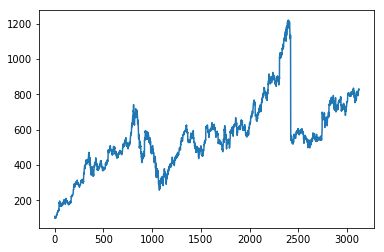

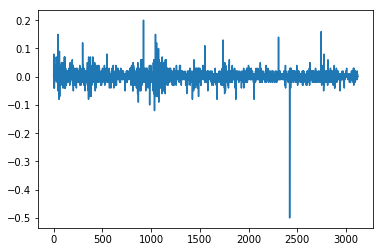

Number of data points: 3125


In [2]:
ed.set_seed(42)

data = pd.read_csv('data/Google.csv')
data = data['Close']
data = data.as_matrix()
plt.plot(data)
plt.show()

## Format data as percent change
for i in reversed(range(1,data.size)):
    data[i] = round((data[i]-data[i-1])/data[i-1],2)
data[0] = 0

plt.plot(data)
plt.show()
N = data.size
print("Number of data points: {}".format(N))


## Model
### Hidden Markov Model

In a Hidden Markov Model the state is not directly known, but the output (dependent on the state) is known. Each state has a probability distribution over the possible output, so from the HMM we can draw some information about the sequence of states from our sequence of data outputs. 

Usually a Hidden Markov Model has a few inferences. One is to infer the probability of an observed sequence. By taking the parameters of the model we can sum over all possible state sequences to get the probability of a particular output. Another is the probability of the latent variables, or given our model parameters and the observed sequence what is the most probable sequence of states. In time series data, HMM's are used for prediction. Using the parameters of the model and the chain of data, the model can predict the next output. 

A Hidden Markov Model is a class of discrete-time processes consisting of observations $y_t$ and latent states $x_t \in {1 \dots K}$ generated by a discrete value Markov Chain. We can see that the joint distributions is 
$$
\begin{align*}
p(x,y) = \pi_0 (x_1) p(y_1|x_1) \Pi_{t=2}^{T} p(x_t|x_{t-1},A)p(y_t|x_t,\phi)
\end{align*}
$$
Where A is the transition matrix defined as  $A_{ij} = P(x_t = j | x_{t-1} = i)$ with $i,j = 1\dots K$ and. $\phi = {\phi_k}_{k=1}^K$ is the emission matrix and $pi_0$ is the initial probabilities. So $\theta = (\pi_0, \phi, A)$ is our HMM parameters. 


In [3]:
timelen = 20 #Chain of stocks for ~1 month
numhidden = 3 #States are increasing stock, decreasing stock, stable stock
numobs = np.unique(data).size
print(np.sort(np.unique(data)))
print(numobs)

p_init = Categorical(probs=tf.fill([numhidden], 1.0/ numhidden))

#Transition Matrix
Trans = tf.nn.softmax(tf.Variable(tf.random_uniform([numhidden, numhidden])), dim = 0)

#Emission Matrix
Emiss = tf.nn.softmax(tf.Variable(tf.random_uniform([numobs, numhidden])), dim = 0)

#HMM model
x = []
y = []
for t in xrange(timelen):
    x_tmp = x[-1] if x else p_init
    x_i = Categorical(probs=Trans[:,x_tmp])
    y_i = Categorical(probs=Emiss[:,x_i])
    x.append(x_i)
    y.append(y_i)


[-0.5  -0.12 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01
  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.2 ]
30


Here we define our model with x and y. We'll pass in our data during the inference part

## Inference

Perform variational inference first using KL diverence.

In [4]:

qf = [Categorical(probs=tf.nn.softmax(tf.Variable(tf.ones(numhidden)))) for t in xrange(timelen)]



Run variational inference for `5000` iterations. As we can see, KL doesn't do a good job for estimating the transition and emission matrix. 

In [14]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    inf_klqp = ed.KLqp(dict(zip(x,qf)), dict(zip(y,data)))
    inf_klqp.run(n_iter=5000, n_print = 5000/10)
    
    print(sess.run(Trans))
    print(sess.run(Emiss))
    #print(sess.run([tmp.probs for tmp in qf]))
    #print(sess.run([tmp.probs for tmp in y]))

5000/5000 [100%] ██████████████████████████████ Elapsed: 54s | Loss: 0.206
[[ 0.19497594  0.18894616  0.18953305]
 [ 0.42248446  0.43192229  0.43608737]
 [ 0.3825396   0.37913156  0.37437955]]
[[  9.99212146e-01   9.99639869e-01   9.99613941e-01]
 [  4.15333998e-05   1.72581385e-05   1.54460922e-05]
 [  2.68732747e-05   1.06513689e-05   8.92647859e-06]
 [  1.62370670e-05   1.08312342e-05   1.18219305e-05]
 [  3.22091400e-05   1.03112243e-05   1.74308716e-05]
 [  2.09608661e-05   1.16124629e-05   1.77042366e-05]
 [  4.12491536e-05   9.09774008e-06   9.92619698e-06]
 [  2.99046897e-05   1.76399117e-05   2.07174671e-05]
 [  2.47616390e-05   9.26666326e-06   1.50784890e-05]
 [  3.16610749e-05   1.59107894e-05   1.43011130e-05]
 [  3.51887502e-05   1.36097906e-05   9.06698097e-06]
 [  2.94172351e-05   7.94618518e-06   1.44824871e-05]
 [  3.27193593e-05   1.55051894e-05   1.00307598e-05]
 [  2.17994912e-05   1.42079953e-05   1.45379645e-05]
 [  4.30122709e-05   1.14207796e-05   1.01792803e-0

# Why is KL bad for time-series data
A lot of developing and research in KL has assumed independence or exchangeable data. Variational Inference for HMM minimizes the difference between the true posterior and an approximation. In doing this it assumes the parameters and hidden variables are independent. While this makes for an efficient iterative solution, it often leads to a poor approximation. 

## What research has been done to fix this
Recent advances in VI have done using stochastic variational inference. However, this has been mostly studied in independent data sets. A paper out of NIPS is using SVI algorithms to learn the parameters of a HMM with time-dependent data. The problem in applying stochastic optimization arises from dependencies in the chain, which must be broken to form small batches of observations. Their algorithm uses the memory decay of the chain to bound the errors. They claim that this new algorithm will help in applying KL to time-series data. 